In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as sla
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [2]:
np.random.seed(42)

The purpose of this project is to implement Logistic Regression and build the Elastic Net Regularization

# Gradient Descent

Let's start with defining a sample 2-variable function:

In [3]:
def f(x):
    """
    :param x: np.array(np.float) of size 2
    :return: float
    """
    return np.sum(np.sin(x)**2, axis=0)


def grad_f(x):
    """
    Gradient of the function f defined above.
    :param x: np.array[2]: float vector of length 2
    :return: np.array[2]: float vector of length 2
    """
    return np.sin(2 * x)

Then implement the gradient descent function:

In [4]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    A function that implements gradient descent to find the minimum of a function f of two variables.
        :param f: scalar function of two variables
        :param grad_f: function that returns the gradient of f (structured like the grad_f function you implemented above)
        :param lr: learning rate of the algorithm
        :param num_iter: number of gradient descent iterations
        :return: np.array[num_iter, 2] pairs of the form (x, f(x))
    """
    if x0 is None:
        x0 = np.random.random(2)

    # We will store the values of the arguments and the function values
    # during the gradient descent in the variable history
    history = []

    # Each iteration of the loop represents a step of gradient descent
    curr_x = x0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_x, f(curr_x)))
        history.append(entry)
        curr_x -= lr * grad_f(curr_x)

    return np.vstack(history)

### Testing the function

In [5]:
steps = grad_descent_2d(f, grad_f, lr=0.1, num_iter=20)
steps

array([[3.74540119e-01, 9.50714306e-01, 7.96162814e-01],
       [3.06443570e-01, 8.56130580e-01, 6.61501405e-01],
       [2.48920419e-01, 7.57129527e-01, 5.32438585e-01],
       [2.01167461e-01, 6.57289308e-01, 4.13213611e-01],
       [1.62010673e-01, 5.60553766e-01, 3.08675973e-01],
       [1.30172552e-01, 4.70495524e-01, 2.22355696e-01],
       [1.04431147e-01, 3.89681303e-01, 1.55185446e-01],
       [8.36964420e-02, 3.19398688e-01, 1.05582063e-01],
       [6.70352177e-02, 2.59775649e-01, 7.04659717e-02],
       [5.36683031e-02, 2.10126580e-01, 4.63846811e-02],
       [4.29552413e-02, 1.69327420e-01, 3.02428152e-02],
       [3.43747570e-02, 1.36105556e-01, 1.95917748e-02],
       [2.75052200e-02, 1.09219378e-01, 1.26378615e-02],
       [2.20069501e-02, 8.75488032e-02, 8.12945761e-03],
       [1.76069810e-02, 7.01283780e-02, 5.21990623e-03],
       [1.40863125e-02, 5.61486426e-02, 3.34776943e-03],
       [1.12694227e-02, 4.49425016e-02, 2.14546343e-03],
       [9.01572898e-03, 3.59660

In [6]:
import numpy as np
import plotly.graph_objects as go

border = 1.5
X, Y = np.meshgrid(np.linspace(-border, border, 100), np.linspace(-border, border, 100))
Z = np.array([f(np.array([x, y])) for x, y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

fig = go.Figure(data=[
    go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')
])

fig.add_trace(go.Scatter3d(
    x=steps[:, 0],
    y=steps[:, 1],
    z=steps[:, 2],
    mode='lines+markers',
    marker=dict(size=8, color='red', symbol='cross'),
    line=dict(color='black', width=5)
))

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        zaxis=dict(range=[-1, 5]),
        aspectratio=dict(x=1, y=1, z=0.7)
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.show();

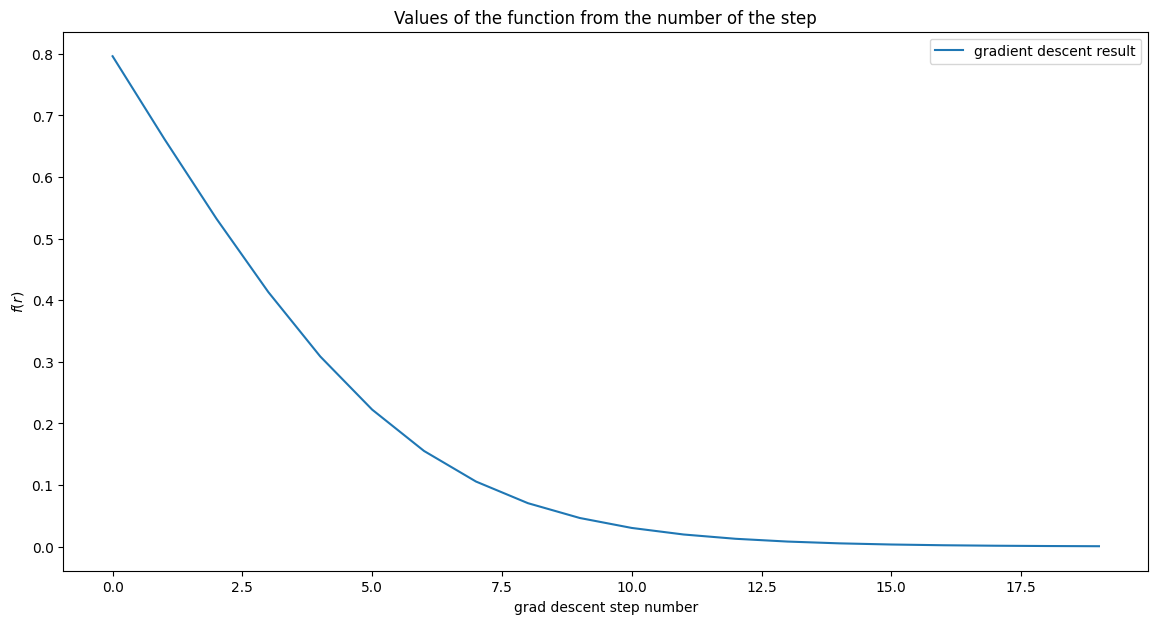

In [8]:
plt.figure(figsize=(14,7))
plt.xlabel('grad descent step number')
plt.ylabel('$f(r)$')
plt.title('Values of the function from the number of the step')

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label='gradient descent result')
plt.legend()

# Batch generation

In [9]:
def generate_batches(X, y, batch_size):
    """
    param X: np.array[n_objects, n_features] --- feature matrix
    param y: np.array[n_objects] --- target vector
    """
    assert len(X) == len(y)
    np.random.seed(42)
    X = np.array(X)
    y = np.array(y)
    perm = np.random.permutation(len(X))

    for batch_start in range(0, (len(X) // batch_size) * batch_size, batch_size):
        batch_indices = perm[batch_start : batch_start + batch_size]
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        yield X_batch, y_batch

Testing the function:

In [10]:
# if length is divisible by batch_size
X_fake = np.arange(100)[:, np.newaxis]
y_fake = np.arange(100) + 1000

X_reconstructed, y_reconstructed = [], []
for X_batch, y_batch in generate_batches(X_fake, y_fake, 10):
    X_reconstructed.append(X_batch)
    y_reconstructed.append(y_batch)

X_reconstructed = np.concatenate(X_reconstructed)
y_reconstructed = np.concatenate(y_reconstructed)

assert (X_fake != X_reconstructed).all(), "Error"
assert (y_fake != y_reconstructed).all(), "Error"

assert (np.sort(X_reconstructed, axis=0) == X_fake).all(), "Error"

In [11]:
# if it's not
X_fake = np.arange(100)[:, np.newaxis]
y_fake = np.arange(100) + 1000

num_batches = 0
for X_batch, y_batch in generate_batches(X_fake, y_fake, 7):
    num_batches += 1

assert num_batches == len(X_fake) // 7, "Error"

# Logistic Regression

In [12]:
def logit(x, w):
    return np.dot(x, w)

def sigmoid(h):
    return 1. / (1 + np.exp(-h))

In [22]:
class MyLogisticRegression(object):
    def __init__(self):
        self.w = None

    def fit(self, X, y, epochs=10, lr=0.1, batch_size=100):
        l, n = X.shape
        if self.w is None:
            np.random.seed(42)
            self.w = np.random.randn(n + 1)

        X_train = np.concatenate((np.ones((l, 1)), X), axis=1)

        losses = []

        for i in range(epochs):
            for X_batch, y_batch in generate_batches(X_train, y, batch_size):

                predictions = self._predict_proba_internal(X_batch)
                loss = self.__loss(y_batch, predictions)

                assert (np.array(loss).shape == tuple()), "Error"

                losses.append(loss)

                grad = self.get_grad(X_batch, y_batch, predictions)
                self.w -= lr * grad

        return losses

    def get_grad(self, X_batch, y_batch, predictions):
        """
        param X_batch: np.array[batch_size, n_features + 1] --- feature matrix
        param y_batch: np.array[batch_size] --- target batch
        param predictions: np.array[batch_size] --- class probability batch

        Output - a column vector of gradients for each weight (np.array[n_features + 1])
        """

        grad_basic = X_batch.T @ (predictions - y_batch)
        assert grad_basic.shape == (X_batch.shape[1],) , "Error"

        return grad_basic

    def _predict_proba_internal(self, X):
        return sigmoid(logit(X, self.w))

    def predict_proba(self, X):
        l, n = X.shape
        X_ = np.concatenate((np.ones((l, 1)), X), axis=1)
        return sigmoid(logit(X_, self.w))

    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold

    def get_weights(self):
        return self.w.copy()

    def __loss(self, y, p):
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))

Testing the function:

In [23]:
np.random.seed(42)
m = MyLogisticRegression()
X = np.random.rand(100,3)
y = np.random.randint(0, 1, size=(100,))
preds = np.random.rand(100)
grads = m.get_grad(X, y, preds)
assert np.allclose(grads, np.array([23.8698149, 25.27049356, 24.4139452])), "Error"

# Elastic Logistic Regrezsion

In [24]:
class MyElasticLogisticRegression(MyLogisticRegression):
    def __init__(self, l1_coef, l2_coef):
        self.l1_coef = l1_coef
        self.l2_coef = l2_coef
        self.w = None

    def get_grad(self, X_batch, y_batch, predictions):

        grad_basic = X_batch.T @ (predictions - y_batch)

        mask = np.ones_like(self.w)
        mask[0] = 0

        grad_l1 = self.l1_coef * np.sign(self.w) * mask
        grad_l2 = 2 * self.l2_coef * self.w * mask

        assert grad_l1[0] == grad_l2[0] == 0, "Error"
        assert grad_basic.shape == grad_l1.shape == grad_l2.shape == (X_batch.shape[1],) , "Error"

        return grad_basic + grad_l1 + grad_l2

Testing the function on the generated data:

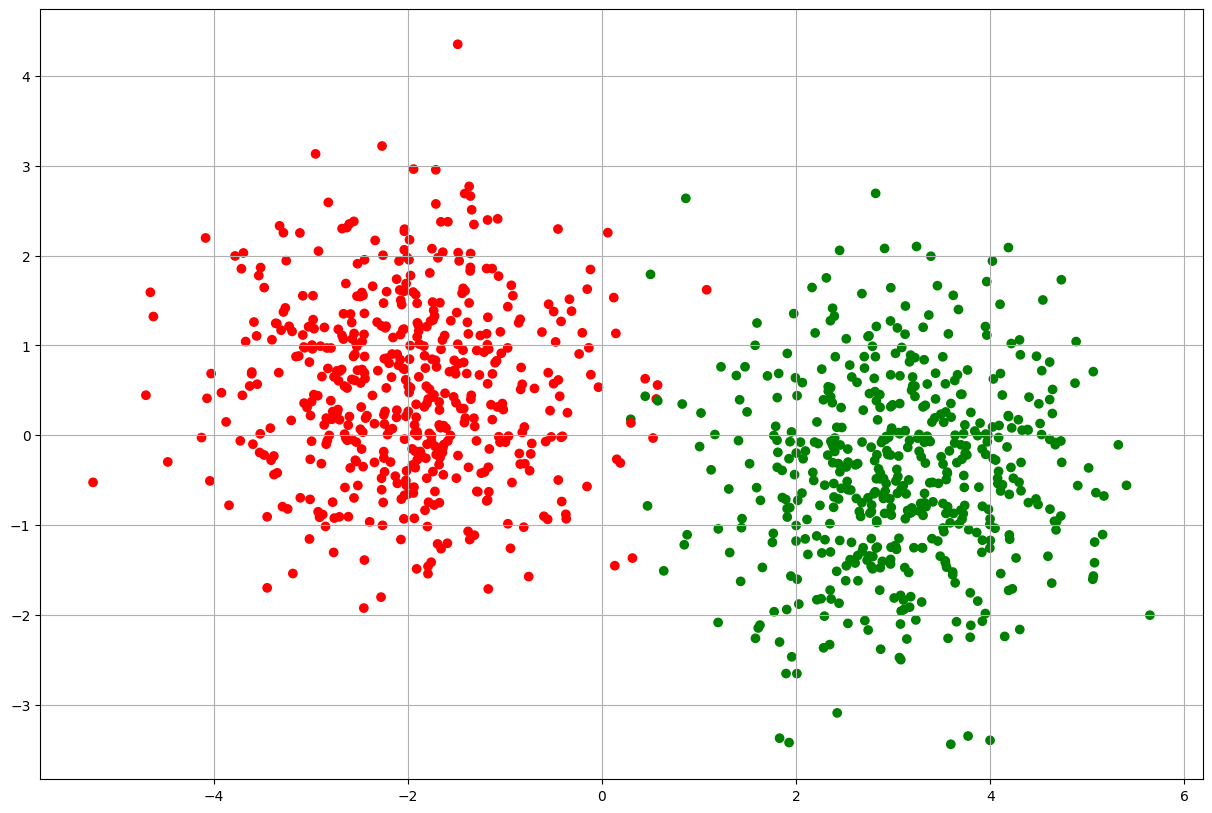

In [25]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=[[-2,0.5],[3,-0.5]], cluster_std=1, random_state=42)

colors = ("red", "green")
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0,1]):
    colored_y[y.ravel() == cl] = str(colors[i])

plt.figure(figsize=(15,10))
plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.grid()
plt.show();

Now let's test it on MNIST dataset and evaluate it through Accuracy metric:

In [26]:
data = pd.read_csv('/content/sample_data/mnist_train_small.csv')
data.head()

,6,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.581,0.582,0.583,0.584,0.585,0.586,0.587,0.588,0.589,0.590
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Since we have a binary classificator, we pick only instances of 0 and 1 from the dataset:

In [27]:
X = data.iloc[:, 1:]
y = data.iloc[:, 0]
X = X[(y == 0) | (y == 1)]
y = y[(y == 0) | (y == 1)]

Now, using cross-validation, we evaluate the model performance:

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

pipeline = make_pipeline(
    StandardScaler(),
    MyElasticLogisticRegression(l1_coef=0.1, l2_coef=0.1)
)
scores = cross_val_score(
    estimator=pipeline,
    X=X,
    y=y,
    cv=5,
    scoring='accuracy'
)
mean_accuracy = scores.mean().round(4)

print(f"Mean accuracy of Logistic Regression for two classes is {mean_accuracy}")

Mean accuracy of Logistic Regression for two classes is 0.9938
